# Perceptual distance

**Run notebook online with Binder:** [![Binder](http://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LabForComputationalVision/plenoptic/master?filepath=examples/04_Perceptual_distance.ipynb)

This tutorial introduces the four perceptual distance functions available in `plenoptic` package: SSIM (structural similarity), MS-SSIM (multiscale structural similarity), NLPD (normalized Laplacian pyramid distance) and NSPD (normalized steerable pyramid distance).

In [1]:
import io
import imageio
import plenoptic as po
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import torch
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## SSIM (structural similarity)

The idea of SSIM index is to decompose the difference between two images into three components: luminance, contrast and structure. For two small image patches $\mathbf{x}$ and $\mathbf{y}$, these three components of difference are defined as:
$$ l(\mathbf{x}, \mathbf{y}) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}, \qquad
c(\mathbf{x}, \mathbf{y}) = \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}, \qquad
s(\mathbf{x}, \mathbf{y}) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3} $$
where $\mu_x$ and $\mu_y$ are the mean of $\mathbf{x}$ and $\mathbf{y}$, $\sigma_x$ and $\sigma_y$ are the standard deviation of $\mathbf{x}$ and $\mathbf{y}$, and $\sigma_{xy}$ is the covariance between $\mathbf{x}$ and $\mathbf{y}$. And $C_1, C_2, C_3$ are small constants. If we ignore the small constants, we can see that the luminance term $l(\mathbf{x}, \mathbf{y})$ is a scale-invariant similarity measurement between $\mu_x$ and $\mu_y$, and the contrast term $c(\mathbf{x}, \mathbf{y})$ is such a measurement between $\sigma_x$ and $\sigma_y$. The structural term $s(\mathbf{x}, \mathbf{y})$ is the correlation coefficient between $\mathbf{x}$ and $\mathbf{y}$, which is invariant to addition and multiplication of constants on $\mathbf{x}$ or $\mathbf{y}$.

Local SSIM between two small image patches $\mathbf{x}$ and $\mathbf{y}$ is defined as (let $C_3 = C_2 / 2$):
$$ d(\mathbf{x}, \mathbf{y}) = l(\mathbf{x}, \mathbf{y}) c(\mathbf{x}, \mathbf{y}) s(\mathbf{x}, \mathbf{y}) = \frac{\left( 2 \mu_x \mu_y + C_1 \right) \left( 2\sigma_{xy} + C_2 \right)} {\left( \mu_x^2 + \mu_y^2 + C_1 \right) \left( \sigma_x^2 + \sigma_y^2 + C_2 \right)} $$
The local SSIM value $d(\mathbf{x}, \mathbf{y}) = 1$ means the two patches are identical and $d(\mathbf{x}, \mathbf{y}) = 0$ means they're very different. When the two patches are negatively correlated, $d(\mathbf{x}, \mathbf{y})$ can be negative. The local SSIM value is bounded between -1 and 1.

For two full images $\mathbf{X}, \mathbf{Y}$, an SSIM map is obtained by computing the local SSIM value $d$ across the whole image. For each position on the images, instead of using a square patch centered on it, a circular-symmeric Gaussian kernel is used to compute the local mean, standard deviation and covariance terms $\mu_{X,i}, \mu_{Y,i}, \sigma_{X,i}, \sigma_{Y,i}, \sigma_{XY,i}$, where $i$ is the pixel index. In this way we can obtain an SSIM map $d_i(\mathbf{X}, \mathbf{Y})$. The values in the SSIM map are averaged to generate a single number, which is the SSIM index:
$$ \text{SSIM}(\mathbf{X}, \mathbf{Y}) = \frac{1}{N} \sum_{i=1}^N d_i(\mathbf{X}, \mathbf{Y}) = \frac{1}{N} \sum_{i=1}^N l_i(\mathbf{X}, \mathbf{Y}) c_i(\mathbf{X}, \mathbf{Y}) s_i(\mathbf{X}, \mathbf{Y}) = \frac{1}{N} \sum_{i=1}^N \frac{\left( 2 \mu_{X,i} \mu_{Y,i} + C_1 \right) \left( 2\sigma_{XY,i} + C_2 \right)} {\left( {\mu_{X,i}}^2 + {\mu_{Y,i}}^2 + C_1 \right) \left( {\sigma_{X,i}}^2 + {\sigma_{Y,i}}^2 + C_2 \right)} $$
where $N$ is the number of pixels of the image. The SSIM index is also bounded between -1 and 1.  In `plenoptic`, the SSIM map is computed by the function `po.metric.ssim_map`, and the SSIM index itself is computed by the function `po.metric.ssim`. For more information, see the original paper:

Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: from error visibility to structural similarity. _IEEE transactions on image processing_, 13(4), 600-612.

### Understanding SSIM

The easiest way to compute the difference between two images is mean square error (MSE), but it does not match the perceptual distance judged by humans. We demonstrate the effectiveness of SSIM by generating five different types of distortions (contrast stretching, mean shifting, JPEG compression, blurring, and salt-pepper noise) with the same MSE, and compute their SSIM values.

In [2]:
def add_jpeg_artifact(img, quality):
    img = (img * 255).astype(np.uint8)
    buffer = io.BytesIO()
    imageio.imwrite(buffer, img, format="jpg", quality=quality)
    return imageio.imread(buffer.getbuffer(), format="jpg").astype(float) / 255

In [3]:
def add_saltpepper_noise(img, threshold):
    np.random.seed(0)
    img_saltpepper = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x = np.random.rand()
            if x < threshold:
                img_saltpepper[i, j] = 0
            elif x > 1 - threshold:
                img_saltpepper[i, j] = 1
    np.random.seed(None)
    return img_saltpepper

In [4]:
def get_distorted_images():
    img = plt.imread("../data/256/einstein.pgm").astype(float) / 255
    img_contrast = np.clip(img + 0.20515 * (2 * img - 1), a_min=0, a_max=1)
    img_mean = np.clip(img + 0.05983, a_min=0, a_max=1)
    img_jpeg = add_jpeg_artifact(img, quality=4)
    img_blur = gaussian_filter(img, sigma=1.983)
    img_saltpepper = add_saltpepper_noise(img, threshold=0.00651)
    img_distorted = torch.tensor([img, img_contrast, img_mean, img_jpeg, img_blur, img_saltpepper], dtype=torch.float32, device=device).unsqueeze(1)
    return img_distorted

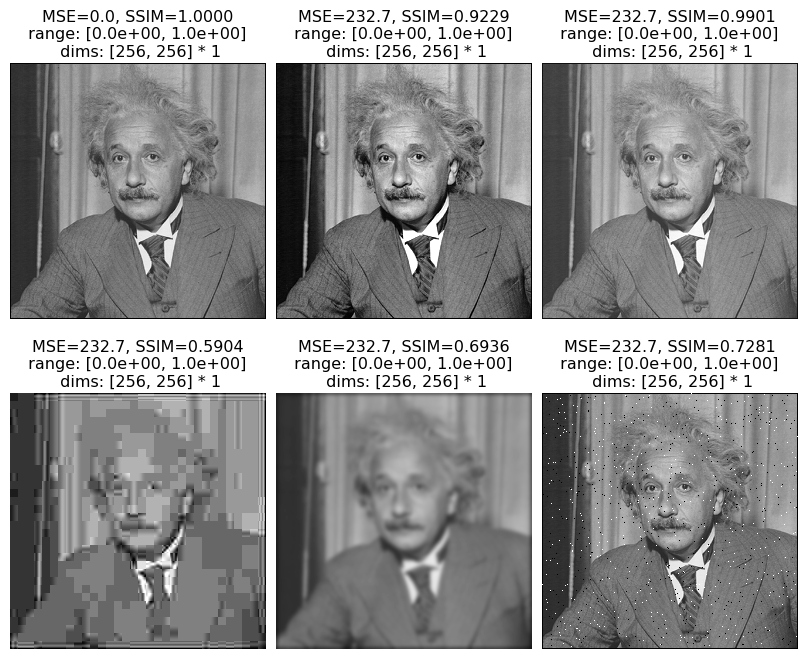

In [5]:
img_distorted = get_distorted_images()
mse_values = torch.square(img_distorted - img_distorted[0]).mean(dim=(1, 2, 3)) * 255**2
ssim_values = po.metric.ssim(img_distorted, img_distorted[[0]])[:, 0]
titles = [f"MSE={mse_values[i]:.1f}, SSIM={ssim_values[i]:.4f}" for i in range(6)]
po.imshow(img_distorted, vrange="auto", title=titles, col_wrap=3);

We can see that the SSIM index matches human perception better than MSE.

While the scalar SSIM index is a concise summary, the SSIM map offers richer information about where perceptual discrepancy is located in the image. Here, we visualize the SSIM map of a JPEG compressed image, and also show the absolute error (absolute value of the difference) for comparison. In both maps, darker means more different.

In [6]:
def get_demo_images():
    img = plt.imread("../data/Parrot.png").astype(float)
    img_jpeg = add_jpeg_artifact(img, quality=6)
    img = torch.tensor(img, dtype=torch.float32, device=device)[None, None]
    img_jpeg = torch.tensor(img_jpeg, dtype=torch.float32, device=device)[None, None]
    ssim_map_small = po.metric.ssim_map(img, img_jpeg)
    ssim_map = torch.ones_like(img)
    ssim_map[:, :, 5:-5, 5:-5] = ssim_map_small
    abs_map = 1 - torch.abs(img - img_jpeg)
    img_demo = torch.cat([img, img_jpeg, ssim_map, abs_map], dim=0).cpu()
    return img_demo

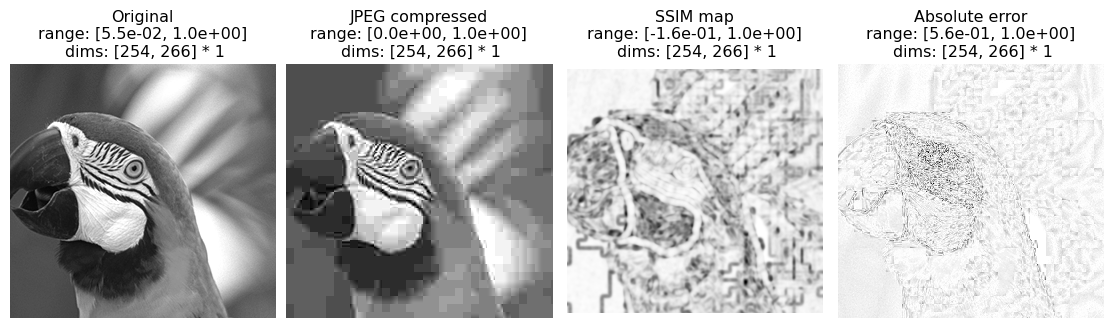

In [7]:
img_demo = get_demo_images()
titles = ["Original", "JPEG compressed", "SSIM map", "Absolute error"]
po.imshow(img_demo, title=titles);

You can judge whether the SSIM map captures the location of perceptual discrepancy better than absolute error.

## MS-SSIM (multiscale structural similarity)

MS-SSIM computes SSIM on multiple scales of the images. To do this, the two images $\mathbf{X}$ and $\mathbf{Y}$ are recursively blurred and downsampled by a factor of 2 to produce two sequences of images: $\mathbf{X}_1, \cdots, \mathbf{X}_M$ and $\mathbf{Y}_1, \cdots, \mathbf{Y}_M$, where $\mathbf{X}_1 = \mathbf{X}$, and $\mathbf{X}_{i+1}$ is obtained by blurring and downsampling $\mathbf{X}_{i}$ (same for $\mathbf{Y}$). Such a sequence is called a Gaussian pyramid. We define a contrast-structural index that does not include luminance component:
$$ \text{CS}(\mathbf{X}, \mathbf{Y}) = \frac{1}{N} \sum_{i=1}^N c_i(\mathbf{X}, \mathbf{Y}) s_i(\mathbf{X}, \mathbf{Y}) = \frac{1}{N} \sum_{i=1}^N \frac{2\sigma_{XY,i} + C_2} {{\sigma_{X,i}}^2 + {\sigma_{Y,i}}^2 + C_2} $$
The MS-SSIM index is defined as:
$$ \text{MS-SSIM}(\mathbf{X}, \mathbf{Y}) = \text{SSIM}(\mathbf{X}_M, \mathbf{Y}_M)^{\gamma_M} \prod_{k=1}^{M-1} \text{CS}(\mathbf{X}_i, \mathbf{Y}_i)^{\gamma_i} $$
where $\gamma_1, \cdots, \gamma_M$ are exponents that determine the relative importance of different scales. They are determined by a human psychophysics experiment and are constrained to sum to 1. When $M=1$, the MS-SSIM index is the same as the SSIM index. In the standard implementation of MS-SSIM, $M = 5$. In `plenoptic`, the MS-SSIM index is computed by the function `po.metric.ms_ssim`. For more information, see the original paper:

Wang, Z., Simoncelli, E. P., & Bovik, A. C. (2003, November). Multiscale structural similarity for image quality assessment. In _The Thrity-Seventh Asilomar Conference on Signals, Systems & Computers_, 2003 (Vol. 2, pp. 1398-1402). IEEE.

## NLPD (normalized Laplacian pyramid distance)

Similar to MS-SSIM, the NLPD is also based on a multiscale representation of the images. Also similar to MS-SSIM, the idea of NLPD is also to separate out the effects of luminance and contrast difference. Unlike MS-SSIM, the NLPD directly performs luminance subtraction and contrast normalization on each scale, and then computes simple square difference. The NLPD uses the Laplacian pyramid for luminance subtraction. Given a Gaussian pyramid $\mathbf{X}_1, \cdots, \mathbf{X}_M$, for $k=1, \cdots, M - 1$, we upsample and blur $\mathbf{X}_{k+1}$ to produce $\mathbf{\hat{X}}_k$, which is a blurry version of $\mathbf{X}_k$, and let $\mathbf{X}'_k = \mathbf{X}_k - \mathbf{\hat{X}}_k$. Define $\mathbf{X}'_M = \mathbf{X}_M$, and we get the Laplacian pyramid $\mathbf{X}'_1, \cdots, \mathbf{X}'_M$. In `plenoptic`, the Laplacian pyramid is implemented by `po.simul.LaplacianPyramid`.

The contrast normalization is achieved by dividing by a local estimation of amplitude:
$$ \mathbf{X}''_{k,i} = \frac{\mathbf{X}'_{k,i}} {f(\mathbf{X}'_{k,N(i)}; \sigma_k, \mathbf{p}_k)}, \qquad f(\mathbf{X}'_{k,N(i)}; \sigma_k, \mathbf{p}_k) = \sigma_k + \sum_{j\in N(i)} p_{k,j-i} |\mathbf{X}'_{k,j}| $$
where $N(i)$ is the neighborhood of pixel $i$ which does not include $i$ itself, and the parameters $\sigma_k$ and $\mathbf{p}_k$ are learned from an image dataset:
$$ \sigma_k = \mathbb{E}_{\mathbf{X},i} \left( |\mathbf{X}'_{k,i}| \right) \qquad \mathbf{p}_k = \arg\min_{\mathbf{p}_k} \mathbb{E}_{\mathbf{X},i} \left( \mathbf{X}'_{k,i} - f(\mathbf{X}'_{k,N(i)}; \sigma_k, \mathbf{p}_k) \right)^2 $$
Note that this learning is performed on the clean images only, without access to the corruption type or human phychophysics data. The sequence $\mathbf{X}''_1, \cdots, \mathbf{X}''_M$ is the normalized Laplacian pyramid. The same procudure is done for $\mathbf{Y}$. The NLPD is defined as:
$$ \text{NLPD}(\mathbf{X}, \mathbf{Y}) = \frac{1}{M} \sum_{k=1}^M \sqrt{\frac{1}{N_k} \sum_{i=1}^{N_k} (\mathbf{X}''_{k,i} - \mathbf{Y}''_{k,i})^2} $$
where $N_k$ is the number of pixels of $\mathbf{X}''_k$. In `plenoptic`, the NLPD is computed by the function `po.metric.nlpd`. For more information, see the original paper:

Laparra, V., Ballé, J., Berardino, A., & Simoncelli, E. P. (2016). Perceptual image quality assessment using a normalized Laplacian pyramid. _Electronic Imaging_, 2016(16), 1-6.

## Comparison of performance

The performance of these perceptual distance metrics can be measured by the correlation with human psychophysics data: the TID2013 dataset consists of 3000 different distorted images (25 clean images x 24 types of distortions x 5 levels of distortions), each with its own mean opinion score (MOS; the perceived difference between the distorted image and its corresponding clean image). We measure the correlation coefficient between MOS and each of MSE, SSIM, MS-SSIM and NLPD. The TID2013 dataset is described in the following paper:

Ponomarenko, N., Jin, L., Ieremeiev, O., Lukin, V., Egiazarian, K., Astola, J., ... & Kuo, C. C. J. (2015). Image database TID2013: Peculiarities, results and perspectives. _Signal processing: Image communication_, 30, 57-77.

In [8]:
def get_tid2013_data(folder="../../Datasets/TID2013/"):
    # TODO: download data, GPU
    reference_images = torch.zeros([25, 1, 384, 512])
    distorted_images = torch.zeros([25, 24, 5, 1, 384, 512])
    for i in range(25):
        reference_images[i] = torch.tensor(np.asarray(Image.open(
            f"{folder}reference_images/i{i + 1:02d}.bmp").convert("L"))) / 255
        for j in range(24):
            for k in range(5):
                distorted_images[i, j, k] = torch.tensor(np.asarray(Image.open(
                    f"{folder}distorted_images/i{i + 1:02d}_{j + 1:02d}_{k + 1}.bmp").convert("L"))) / 255
    distorted_images = distorted_images[:, [0] + list(range(2, 17)) + list(range(18, 24))]  # Remove color distortions

    with open(f"{folder}mos.txt", "r", encoding="utf-8") as g:
        mos_values = list(map(float, g.readlines()))
    mos_values = np.array(mos_values).reshape([25, 24, 5])
    mos_values = mos_values[:, [0] + list(range(2, 17)) + list(range(18, 24))]  # Remove color distortions
    return reference_images, distorted_images, mos_values

def correlate_with_tid(func_list, name_list):
    reference_images, distorted_images, mos_values = get_tid2013_data()
    distance = torch.zeros([len(func_list), 25, 22, 5])
    for i, func in enumerate(func_list):
        for j in range(25):
            distance[i, j] = func(reference_images[[j]], distorted_images[j].flatten(0, 1)).reshape(22, 5)

    fig, axs = plt.subplots(1, len(func_list), figsize=(len(func_list) * 6, 6))
    edgecolor_list = ["m", "c", "k", "g", "r"]
    facecolor_list = [None, "none", "none", None, "none"]
    shape_list = ["x", "s", "o", "*", "^"]
    distortion_names = ["Additive Gaussian noise",
                        "Spatially correlated noise",
                        "Masked noise",
                        "High frequency noise",
                        "Impulse noise",
                        "Quantization noise",
                        "Gaussian blur",
                        "Image denoising",
                        "JPEG compression",
                        "JPEG2000 compression",
                        "JPEG transmission errors",
                        "JPEG2000 transmission errors",
                        "Non eccentricity pattern noise",
                        "Local block-wise distortions of different intensity",
                        "Mean shift (intensity shift)",
                        "Contrast change",
                        "Multiplicative Gaussian noise",
                        "Comfort noise",
                        "Lossy compression of noisy images",
                        "Image color quantization with dither",
                        "Chromatic aberrations",
                        "Sparse sampling and reconstruction"]

    for i, name in enumerate(name_list):
        for j in range(22):
            edgecolor = edgecolor_list[j % 5]
            facecolor = facecolor_list[j // 5]
            if facecolor is None:
                facecolor = edgecolor
            axs[i].scatter(distance[i, :, j].flatten(), mos_values[:, j].flatten(), s=20,
                           edgecolors=edgecolor, facecolors=facecolor,
                           marker=shape_list[j // 5], label=distortion_names[j])
        pearsonr_value = pearsonr(-mos_values.flatten(), distance[i].flatten())[0]
        spearmanr_value = spearmanr(-mos_values.flatten(), distance[i].flatten())[0]
        axs[i].set_title(
            f"pearson {pearsonr_value:.4f}, spearman {spearmanr_value:.4f}")
        axs[i].set_xlabel(name)
        axs[i].set_ylabel("MOS")
    lines, labels = axs[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc="lower center", bbox_to_anchor=(0.5, 1.0))
    plt.tight_layout()
    plt.show()

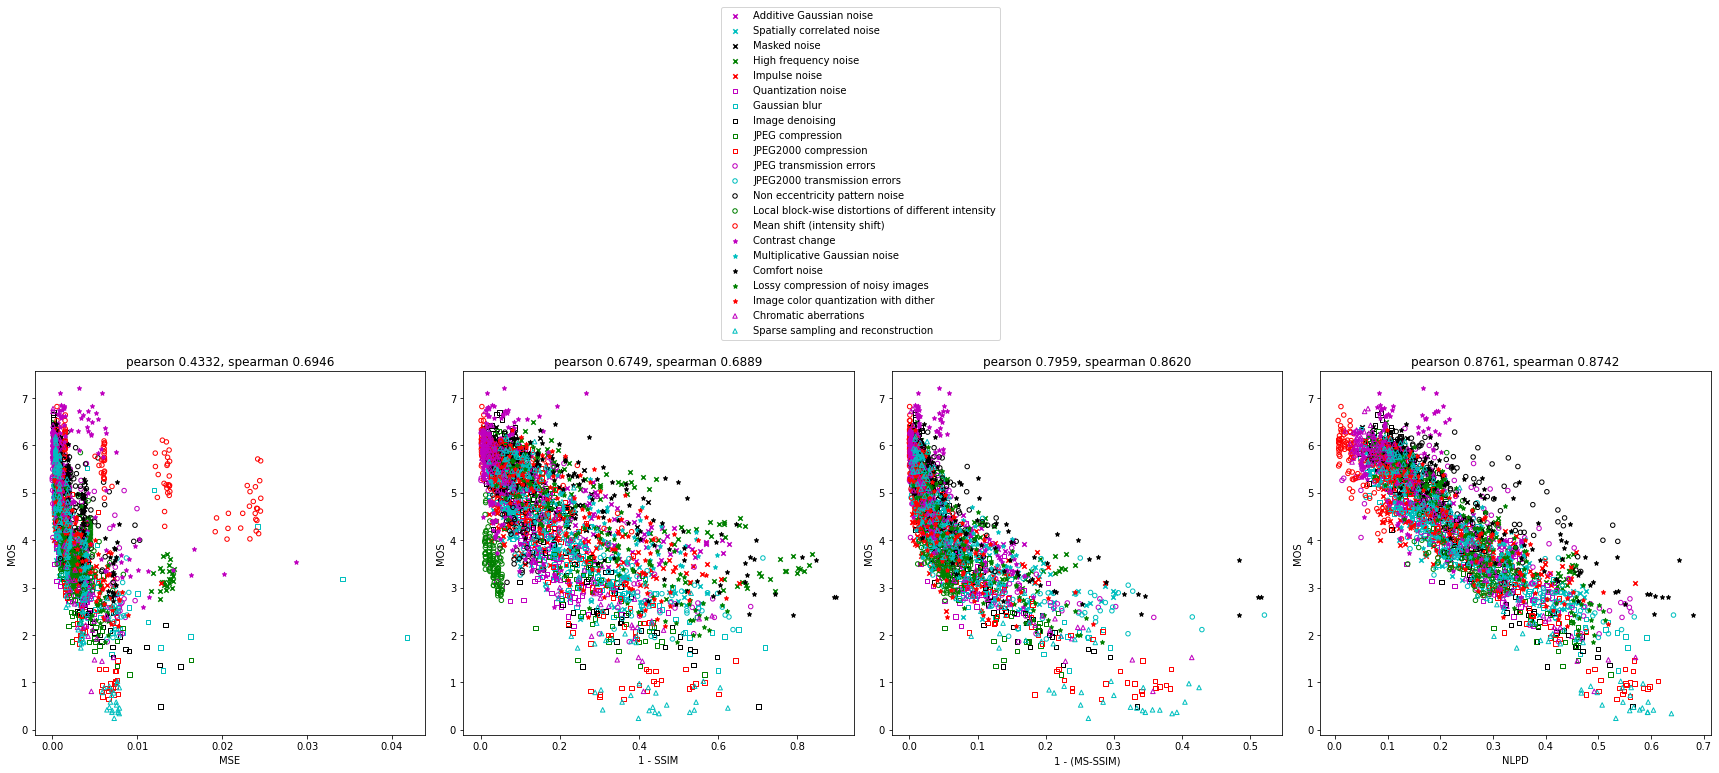

In [9]:
def mse(img1, img2):
    return torch.square(img1 - img2).mean(dim=(-2, -1))

def one_minus_ssim(img1, img2):
    return 1 - po.metric.ssim(img1, img2)

def one_minus_msssim(img1, img2):
    return 1 - po.metric.ms_ssim(img1, img2)
    
correlate_with_tid(func_list=[mse, one_minus_ssim, one_minus_msssim, po.metric.nlpd], name_list=["MSE", "1 - SSIM", "1 - (MS-SSIM)", "NLPD"])

Each point in the figures is a distorted image, and the color/shape indicates the distortion type. The Pearson's and Spearman's correlation coefficient between MOS and each perceptual distance metric is shown above the figures. We can see that the performance of the metrics, measured by the correlation coefficients, increases from left to right.